In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from ipynb.fs.full.util import get_one
from ipynb.fs.full.util import load_candidates
from ipynb.fs.full.util import to_X_y

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.svm import LinearSVC

In [2]:
df_result = pd.read_csv("../data/dataset_cleaned.csv", na_values=["_NULL_"], keep_default_na=False)
df_metamap = pd.read_csv("../data/metamap.csv", na_values=["_NULL_"], keep_default_na=False)

df = pd.merge(df_result, df_metamap, how="inner", on=["test_key", "result_key"])

In [3]:
df_test_outcome = df[
    df["test_outcome"].notna()
]

display(df_test_outcome.shape)

(115347, 16)

In [4]:
df_organism_genus = df[
    df["level_1"].notna()
    & (df["level_1"] != "*not in hierarchy")
    & (df["level_1"] != "*not in scope")
]

display(df_organism_genus.shape)

(38370, 16)

In [5]:
# =======================================
# train an ML classifier for Test Outcome

vectorizer = CountVectorizer(ngram_range=(1, 1), min_df=5)
X, y, _ = to_X_y(vectorizer, df_test_outcome, "test_outcome")

classifier = LinearSVC(random_state=1731, max_iter=10000)
classifier.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=1731, tol=0.0001,
     verbose=0)

In [6]:
# =============================
# train the symbolic classifier

dictionary = set()

for raw_label in df_organism_genus["level_1"]:
    labels = raw_label.split(" or ")
    dictionary.update(labels)

if "influzena" in dictionary:
    dictionary.remove("influzena")
    dictionary.add("influenza")

if "*not found" in dictionary:
    dictionary.remove("*not found")

display(dictionary)

{'adenovirus',
 'bordetella',
 'campylobacter',
 'chlamydia',
 'clostridium',
 'coronavirus',
 'corynebacterium',
 'enterovirus',
 'escherichia',
 'haemophilus',
 'hepatitis c virus',
 'herpesvirus',
 'hiv',
 'human bocavirus',
 'human metapneumovirus',
 'influenza',
 'listeria',
 'neisseria',
 'parainfluenza',
 'respiratory syncytial virus',
 'rhinovirus',
 'salmonella',
 'shigella',
 'streptococcus',
 'treponema',
 'trichomonas',
 'vibrio',
 'yersinia'}

In [7]:
# =======================
# classify the given data

def classify_row(row):
    document = row["result_full_description"]
    X_test = vectorizer.transform([document])
    test_outcome_pred = classifier.predict(X_test)[0]
    
    if test_outcome_pred == "negative":
        return "*not found"
    
    candidates = load_candidates(row["candidates"])
    if not candidates:
        return "*not found"
    
    for candidate in candidates:
        words = candidate.split()
        for i in range(len(words), 1 - 1, -1):
            level_1 = " ".join(words[:i])
            if level_1 in dictionary:
                return "influzena" if level_1 == "influenza" else level_1
    
    return get_one(candidates)

y_pred = df_organism_genus.apply(classify_row, axis=1)

In [8]:
y_true = df_organism_genus["level_1"]

accuracy_score(y_true, y_pred)

0.8980192859004431

In [9]:
classes = sorted(y_true.unique().tolist())
display(classes)

['*not found',
 'bordetella',
 'campylobacter',
 'chlamydia',
 'clostridium',
 'coronavirus',
 'corynebacterium',
 'escherichia',
 'haemophilus',
 'hepatitis c virus',
 'herpesvirus',
 'hiv',
 'human bocavirus',
 'human metapneumovirus',
 'influzena',
 'listeria',
 'neisseria',
 'parainfluenza or adenovirus',
 'respiratory syncytial virus',
 'rhinovirus or enterovirus',
 'salmonella',
 'shigella',
 'streptococcus',
 'treponema',
 'trichomonas',
 'vibrio',
 'yersinia']

In [10]:
precision = precision_score(y_true, y_pred, labels=classes, average=None)
display(precision)

recall = recall_score(y_true, y_pred, labels=classes, average=None)
display(recall)

C:\Users\william.lu\AppData\Roaming\Python\Python36\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.88663515, 0.98006645, 0.94094488, 0.7483871 , 0.99576271,
       0.        , 1.        , 0.97950378, 0.98678414, 0.95525424,
       0.04878049, 0.96653005, 0.73684211, 0.61111111, 0.91596639,
       1.        , 0.76498423, 0.        , 0.57142857, 0.        ,
       0.96328671, 0.78193146, 0.99924357, 0.96153846, 0.        ,
       0.98591549, 0.95209581])

array([0.95025607, 0.98993289, 0.66388889, 0.47540984, 0.93253968,
       0.        , 1.        , 0.72931727, 1.        , 0.98854069,
       0.00743494, 0.95802302, 0.20740741, 0.10185185, 0.27386935,
       0.98529412, 0.9454191 , 0.        , 0.17721519, 0.        ,
       0.88301282, 0.92962963, 0.99848828, 0.55555556, 0.        ,
       0.93333333, 0.68534483])

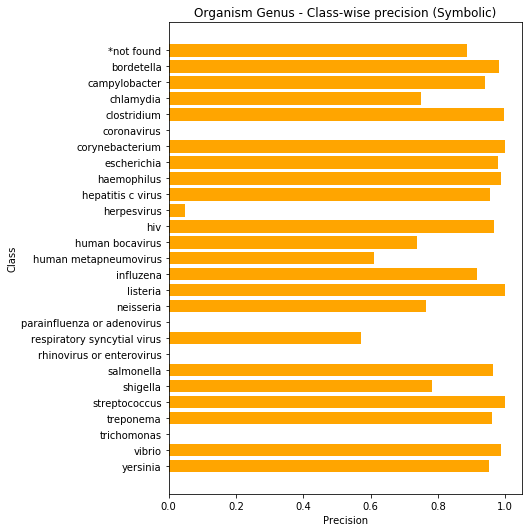

In [11]:
plt.figure(figsize=(7.5, 7.5))

y = [-x for x in range(len(classes))]
width = precision

plt.barh(y, width, color="orange")

plt.yticks(y, classes)

plt.xlabel("Precision")
plt.ylabel("Class")
plt.title("Organism Genus - Class-wise precision (Symbolic)")

plt.tight_layout()
plt.savefig("../figs/ogs_precision.png")

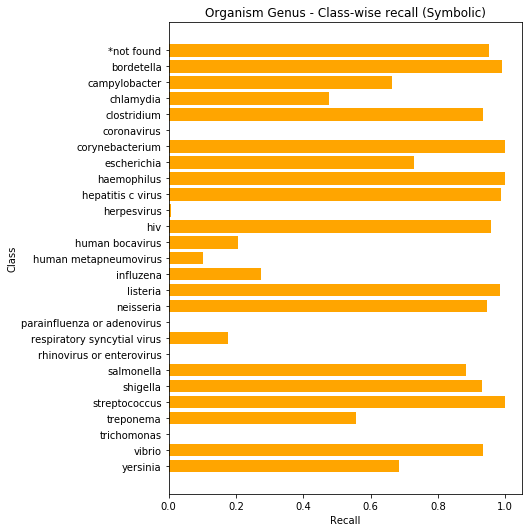

In [12]:
plt.figure(figsize=(7.5, 7.5))

y = [-x for x in range(len(classes))]
width = recall

plt.barh(y, width, color="orange")

plt.yticks(y, classes)

plt.xlabel("Recall")
plt.ylabel("Class")
plt.title("Organism Genus - Class-wise recall (Symbolic)")

plt.tight_layout()
plt.savefig("../figs/ogs_recall.png")